<a href="https://colab.research.google.com/github/prithwis/BigRe/blob/master/AI_DL_Chapter_7A_Reinforcement_Learning_TaxiV3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://1.bp.blogspot.com/-WAjYIaQofo0/YEB0cQsSGSI/AAAAAAAAkoE/TpQcWBRGtu0N010lmiTS9cFHuGwXB45PQCLcBGAsYHQ/s16000/colabHeader00.png)<br>

<hr>

[Prithwis Mukerjee](http://www.yantrajaal.com) / [Praxis Business School](http://praxis.ac.in/) / [Book Website](http://aidl4managers.blogspot.com) 

#Deprecated - DO NOT USE this notebook
Use [this notebook](https://github.com/Praxis-QR/DeepLearning/blob/main/AI_DL_Chapter_7A_Reinforcement_Learning_TaxiV3_v2.ipynb) instead.

#Taxi

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/ <br>
https://medium.com/swlh/introduction-to-q-learning-with-openai-gym-2d794da10f3d

#Imports, Installs

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
from time import sleep
import numpy as np
import gym
env = gym.make("Taxi-v3").env

#Graphical Displays

In [ ]:
print("Action Space",env.action_space)
print("State Space",env.observation_space)

Action Space Discrete(6)
State Space Discrete(500)


In [ ]:
# show a graphical representation of any state
# along with the reward table P associated with 6 possible actions in this state
# default values are used as sample if no input is provided
#
def showStateVec(txR=3, txC=1,pxI=2,des=0):
    state = env.encode(txR,txC,pxI,des)
    #env.reset()
    env.s = state
    #print("Action Space",env.action_space)
    #print("State Space",env.observation_space)
    print("State ", env.s, list(env.decode(env.s)))
    env.render()
    for k,v in env.P[state].items():
        print(v)

# instead of using the vector representation of the state
# we use the state identification number
#
def showStateNum(state=328):
    v = list(env.decode(state))
    showStateVec(v[0],v[1],v[2],v[3])

In [ ]:
# taxi at 3,1, passenger at 2, destination = 0
# note, moving to the WEST is not possible, the position does not change
showStateVec(3,1,2,0)

State  328 [3, 1, 2, 0]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

[(1.0, 428, -1, False)]
[(1.0, 228, -1, False)]
[(1.0, 348, -1, False)]
[(1.0, 328, -1, False)]
[(1.0, 328, -10, False)]
[(1.0, 328, -10, False)]


In [ ]:
# taxi at 4,3 passenger in taxi
# destination is same as taxi position
# a dropoff shows ride completion is True
# change destination from 3 to 4 and note how rewards and completion status change
#
showStateVec(4,3,4,3)

State  479 [4, 3, 4, 3]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

[(1.0, 479, -1, False)]
[(1.0, 379, -1, False)]
[(1.0, 499, -1, False)]
[(1.0, 479, -1, False)]
[(1.0, 479, -10, False)]
[(1.0, 475, 20, True)]


In [ ]:
# taxi at 0,0 passenger in position 0
# destination is 2
#
showStateVec(0,0,0,2)
#trying to move North or West is impossible,
#leaves system at same state 0

State  2 [0, 0, 0, 2]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

[(1.0, 102, -1, False)]
[(1.0, 2, -1, False)]
[(1.0, 22, -1, False)]
[(1.0, 2, -1, False)]
[(1.0, 18, -1, False)]
[(1.0, 2, -10, False)]


In [ ]:
#check what happens when system moves to state 102, 22, 18
# 102 moves South without pickup
# 22 moves East without pickup
# 18 picks up passenger, stay same place
# if tries to drop, stays in same state, but collects large penalty
showStateNum(22)

State  22 [0, 1, 0, 2]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

[(1.0, 122, -1, False)]
[(1.0, 22, -1, False)]
[(1.0, 22, -1, False)]
[(1.0, 2, -1, False)]
[(1.0, 22, -10, False)]
[(1.0, 22, -10, False)]


In [ ]:
# taxi at 0,4 passenger in taxi
# destination is 1 (current taxi location)
#
showStateVec(0,4,4,1)
#trying to move North or West is impossible,
#leaves system at same state 0

State  97 [0, 4, 4, 1]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

[(1.0, 197, -1, False)]
[(1.0, 97, -1, False)]
[(1.0, 97, -1, False)]
[(1.0, 77, -1, False)]
[(1.0, 97, -10, False)]
[(1.0, 85, 20, True)]


#Single Trip

In [ ]:
# One trip of the Taxi
# default values are Not trained and starting from state=328
# these can be overwritten
# returns number of steps required to complete, penalties accrued, and a movie of the trip that can be played back
#
def OneTrip(trngStatus='NotTrained',state=328,):
    env.s = state  # set environment to illustration's state
    epochs = 0
    penalties, reward = 0, 0
    frames = [] # for animation
    done = False
    while not done:
        if not(trngStatus == 'Trained'):
            action = env.action_space.sample()  # take random action
        else:
            if np.all(Q[state] == Q[state][0]):
                action = env.action_space.sample()  # take random action
            else:
                action = np.argmax(Q[state])  # take trained action
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward,
            'state2':list(env.decode(state)),
            'completion': done
            }
        )
        #print('Epoch: ', epochs,' State ',state)
        epochs += 1
        if (epochs > 10000):
            print('Non Ending Loop')
            done = True
    return(epochs, penalties,frames)


In [ ]:
e,p,movieNT = OneTrip()
print(e,p)

1071 347


In [ ]:
def playBack(frames,speed='Fast',cut=True):
    for i, cframe in enumerate(frames):
        clear_output(wait=True)
        print(cframe['frame'])
        print("Step ",i,' Action ', cframe['action'],' Reward ',cframe['reward'])
        print(f'State: ',cframe['state'],' -> ',cframe['state2'])
        
        if (cframe['completion']):
            print('Done')
        if (speed == 'Fast'):
            sleep(.1)
        else:
            sleep(1)
        if cut and (i > 200):
            print('Cut!')
            return(i)
    return(i)

In [ ]:
playBack(movieNT)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step  201  Action  0  Reward  -1
State:  448  ->  [4, 2, 2, 0]
Cut!


201

#Training # 1

In [ ]:
#Train the system
#
def RLTrainer(alpha, gamma, epsilon, total_episodes):

    global all_epochs, all_penalties, Q
    # For plotting metrics
    all_epochs = []
    all_penalties = []

    Q = np.zeros([env.observation_space.n, env.action_space.n])

    for i in range(1, total_episodes+1):
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(Q[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 
            
            old_value = Q[state, action]
            next_max = np.max(Q[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            Q[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            
        if i % 100 == 0:
            clear_output(wait=True)
            print('Episode ',i)
        all_epochs.append(epochs)
        all_penalties.append(penalties)
    print("Training finished.\n")

In [ ]:
%%time
"""Training the agent"""

# Hyperparameters
_alpha = 0.1
_gamma = 0.6
_epsilon = 0.1
total_episodes = 100000

RLTrainer(_alpha, _gamma, _epsilon, total_episodes)


Episode  100000
Training finished.

CPU times: user 1min 7s, sys: 17.6 s, total: 1min 25s
Wall time: 1min 9s


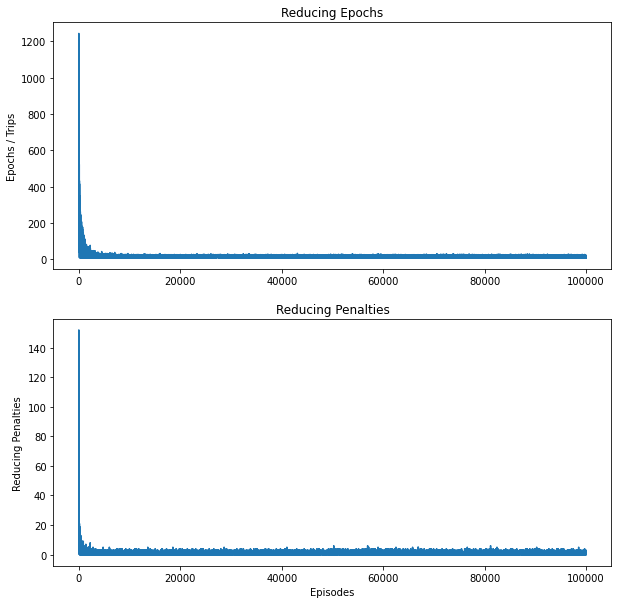

In [ ]:
#Visualizing results and total reward over all episodes
x = range(total_episodes)
plt.rcParams["figure.figsize"] = (10,10)

plt.subplot(2, 1, 1)
plt.plot(x, all_epochs)
plt.title('Reducing Epochs')
plt.ylabel('Epochs / Trips')


plt.subplot(2, 1, 2)
plt.plot(x, all_penalties)
plt.title('Reducing Penalties')
plt.xlabel('Episodes')
plt.ylabel('Reducing Penalties')

plt.show()

#Review of Training #1

In [ ]:
e,p,movieRT = OneTrip('Trained',328)
print(e,p)

10 0


In [ ]:
playBack(movieRT,'Slow')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step  9  Action  5  Reward  20
State:  0  ->  [0, 0, 0, 0]
Done


9

In [ ]:
E, P, samples = [],[],1000
for _ in range(0,samples):
    startState=random.randint(0,499)
    e,p,movieRT = OneTrip('Trained',startState)
    E.append(e)
    P.append(p)
    #print(startState,e,p)
meanE = round(sum(E)/len(E))
meanP = round(sum(P)/len(P))
print('mean of ',samples,' samples >' 'epochs: ', meanE, 'penalties: ', meanP)


Non Ending Loop
Non Ending Loop
mean of  1000  samples >epochs:  107 penalties:  26


percentile:  0 epochs:  1 penalties:  0
percentile:  5 epochs:  4 penalties:  0
percentile:  10 epochs:  6 penalties:  0
percentile:  15 epochs:  7 penalties:  0
percentile:  20 epochs:  8 penalties:  0
percentile:  25 epochs:  9 penalties:  0
percentile:  30 epochs:  10 penalties:  0
percentile:  35 epochs:  11 penalties:  0
percentile:  40 epochs:  12 penalties:  0
percentile:  45 epochs:  12 penalties:  0
percentile:  50 epochs:  13 penalties:  0
percentile:  55 epochs:  13 penalties:  0
percentile:  60 epochs:  14 penalties:  0
percentile:  65 epochs:  15 penalties:  0
percentile:  70 epochs:  15 penalties:  0
percentile:  75 epochs:  16 penalties:  0
percentile:  80 epochs:  17 penalties:  0
percentile:  85 epochs:  81 penalties:  22
percentile:  90 epochs:  285 penalties:  90
percentile:  95 epochs:  569 penalties:  186
percentile:  100 epochs:  10001 penalties:  615


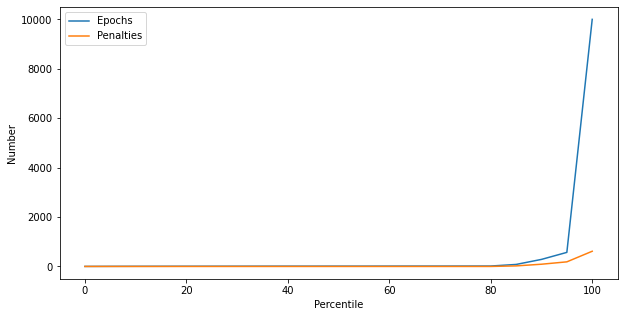

In [ ]:
Percentile,NumEpochs,NumPenalties = [],[],[]
for z in range(0,101,5):
    print('percentile: ',z,'epochs: ', round(np.percentile(E,z)), 'penalties: ', round(np.percentile(P,z)))
    Percentile.append(z)
    NumEpochs.append(np.percentile(E,z))
    NumPenalties.append(np.percentile(P,z))

plt.rcParams["figure.figsize"] = (10,5)
plt.plot(Percentile, NumEpochs, label='Epochs')
plt.plot(Percentile, NumPenalties,label='Penalties')
plt.xlabel('Percentile')
plt.ylabel('Number')
plt.legend(loc='best')
plt.show()

#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png) The contents of this website are released under creative commons 